In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
tf.random.set_seed(42)

file_name = '/content/drive/My Drive/Colab Notebooks/defect/Product_defect/extrusion.csv'

df = pd.read_csv(file_name)
df.info()

columns = df.columns.tolist()
print(columns)


print(df.shape)
print(np.shape(columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226536 entries, 0 to 226535
Columns: 470 entries, Datum to ST114_VARWdTensVis
dtypes: float64(469), object(1)
memory usage: 812.3+ MB
['Datum', 'ST0_VARActAuftrag', 'ST110_VARExtr_0_HeizungZone_3_Regler_Y', 'ST110_VARExtr_0_HeizungZone_3_SollTemp', 'ST110_VARExtr_0_HeizungZone_4_Konfig', 'ST110_VARExtr_0_HeizungZone_4_Regler_X', 'ST110_VARExtr_0_HeizungZone_4_Regler_Y', 'ST110_VARExtr_0_HeizungZone_4_SollTemp', 'ST110_VARExtr_0_HeizungZone_5_Konfig', 'ST110_VARExtr_0_HeizungZone_5_Regler_X', 'ST110_VARExtr_0_HeizungZone_5_Regler_Y', 'ST110_VARExtr_0_HeizungZone_5_SollTemp', 'ST110_VARExtr_0_HeizungZone_6_Konfig', 'ST110_VARExtr_0_HeizungZone_6_Regler_X', 'ST110_VARExtr_0_HeizungZone_6_Regler_Y', 'ST110_VARExtr_0_HeizungZone_6_SollTemp', 'ST110_VARExtr_0_HeizungZone_7_Konfig', 'ST110_VARExtr_0_HeizungZone_7_Regler_X', 'ST110_VARExtr_0_HeizungZone_7_Regler_Y', 'ST110_VARExtr_0_HeizungZone_7_SollTemp', 'ST110_VARExtr_0_HeizungZone_8_Konfig

In [3]:
# 날짜 삭제
del df['Datum']
columns.remove('Datum')

In [4]:
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min(axis = 0)) / (x_np.max(axis = 0) - x_np.min(axis = 0))

In [5]:
# Target index 찾기

# target_index = columns.index('ST110_VAREx_0_SDickeIst') # 두께값예측 regression
target_index = columns.index('ST110_VAREx_0_RegelungEin') # 결함예측 classification

In [6]:
X = np.asarray(df)[:, :]
Y = np.asarray(df)[:, target_index]

print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

X.shape:  (226536, 469)
Y.shape:  (226536,)


In [7]:
# null값이 있는 모든 row를 찾기
null_row = []

for i in range(len(X)):
    for j in range(len(columns)):
        if pd.isnull(X[i,j]):
            null_row.append(i)

# 모든 row 출력
null_row = sorted(list(set(null_row)))

print(null_row)
print(len(null_row))

[18398, 18399, 18400, 18454, 20979, 24019, 24035, 58210, 58211, 58212, 62021, 62022, 62023, 62024, 62025, 62026, 62027, 62028, 62029, 70978, 71524, 71576, 78210, 82932, 82933, 82934, 87052, 87053, 91158, 96208, 96209, 96210, 96211, 96212, 96213, 96214, 96215, 96216, 96217, 96218, 96219, 96220, 96221, 96222, 96223, 96224, 96225, 96226, 96227, 96228, 96229, 96230, 96231, 96232, 96233, 96234, 96235, 96236, 96237, 96238, 96239, 96240, 96241, 96242, 96243, 96244, 96245, 96246, 96247, 96248, 96249, 96250, 96251, 96252, 96253, 96254, 96255, 96256, 96257, 96258, 96259, 96260, 96261, 96262, 96263, 96264, 96265, 96266, 96267, 96268, 96269, 96270, 96271, 96272, 96273, 96274, 96275, 96276, 96277, 96278, 96279, 96280, 96281, 96282, 96283, 96284, 96285, 96286, 96287, 96288, 96289, 96290, 96291, 96292, 96293, 96294, 96295, 96296, 96297, 96298, 96299, 96300, 96301, 96302, 96303, 96304, 96305, 96306, 96307, 96308, 96309, 96310, 96311, 96312, 96313, 96314, 96315, 96316, 96317, 96318, 96319, 96320, 96321

In [8]:
seq_length = 60
predict_length = 15
input_columns = len(columns)

num_Data = 1

if null_row[0] - 1 > 3000:
    X0 = X[:null_row[0], :]
    Y0 = Y[:null_row[0]]

for i in range(1, len(null_row)):
    if null_row[i] - null_row[i-1] - 1 > 3000:
        locals()['X{}'.format(num_Data)] = X[null_row[i-1] + 1 : null_row[i], :]
        locals()['Y{}'.format(num_Data)] = Y[null_row[i-1] + 1 : null_row[i]]
        num_Data += 1

In [9]:
selected_feature_idx = [130, 156, 157, 253, 274, 278, 288, 465]

for i in range(num_Data):
    locals()['x{}'.format(i)] = min_max_scaling(locals()['X{}'.format(i)][:, selected_feature_idx])
    locals()['y{}'.format(i)] = min_max_scaling(locals()['Y{}'.format(i)])

    dataX = []
    dataY = []
    for j in range(0, len(locals()['y{}'.format(i)]) - seq_length - predict_length + 1):
        _x = locals()['x{}'.format(i)][j : j + seq_length]
        _y = locals()['y{}'.format(i)][j + seq_length : j + seq_length + predict_length]
        dataX.append(_x)
        dataY.append(_y)

    locals()['dataX{}'.format(i)] = np.array(dataX)
    locals()['dataY{}'.format(i)] = np.array(dataY)
    locals()['trainX{}'.format(i)], locals()['testX{}'.format(i)], locals()['trainY{}'.format(i)], locals()['testY{}'.format(i)] = train_test_split(locals()['dataX{}'.format(i)], locals()['dataY{}'.format(i)], test_size=0.3, shuffle = False)
    locals()['trainY{}'.format(i)] = tf.expand_dims(locals()['trainY{}'.format(i)],2)
    locals()['testY{}'.format(i)] = tf.expand_dims(locals()['testY{}'.format(i)],2)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# LSTM 모델 / LSTM Model
model = Sequential([
    LSTM(128, input_shape = (seq_length, len(selected_feature_idx)), return_sequences=True, activation = 'sigmoid'),
    Dropout(0.5),
    LSTM(64, return_sequences=True, activation = 'sigmoid'),
    Dropout(0.5),
    LSTM(64, return_sequences=False, activation = 'sigmoid'),
    Dropout(0.5),
    Dense(predict_length, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           70144     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 15)                9

In [11]:
# 모델 학습 설정 및 진행 / Model Training options and Progress
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=10)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer = adam)

idxs = []
for i in range(num_Data):
    idxs.append(i)

remove_idxs = [1, 5, 7, 8, 11, 12, 15, 18]
for i in range(len(remove_idxs)):
    idxs.remove(remove_idxs[i])

for i in idxs:
    locals()['history{}'.format(i)] = model.fit(locals()['trainX{}'.format(i)], locals()['trainY{}'.format(i)], batch_size = 100, epochs = 10, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
116/116 [==============================] - 39s 309ms/step - loss: 0.4960 - val_loss: 0.4490
Epoch 2/10
116/116 [==============================] - 35s 303ms/step - loss: 0.3752 - val_loss: 0.4442
Epoch 3/10
116/116 [==============================] - 35s 306ms/step - loss: 0.3366 - val_loss: 0.2896
Epoch 4/10
116/116 [==============================] - 35s 302ms/step - loss: 0.1924 - val_loss: 0.2489
Epoch 5/10
116/116 [==============================] - 35s 302ms/step - loss: 0.1667 - val_loss: 0.2368
Epoch 6/10
116/116 [==============================] - 35s 303ms/step - loss: 0.1600 - val_loss: 0.2365
Epoch 7/10
116/116 [==============================] - 35s 304ms/step - loss: 0.1428 - val_loss: 0.2314
Epoch 8/10
116/116 [==============================] - 35s 304ms/step - loss: 0.1492 - val_loss: 0.2302
Epoch 9/10
116/116 [==============================] - 35s 304ms/step - loss: 0.1450 - val_loss: 0.2186
Epoch 10/10
116/116 [==============================] - 35s 303ms/step - l

In [12]:
for i in idxs:
    model.evaluate(locals()['testX{}'.format(i)], locals()['testY{}'.format(i)])

50/50 [==============================] - 2s 35ms/step - loss: 0.3013


In [13]:
# 예측
for i in idxs:
    locals()['pred{}'.format(i)] = model.predict(locals()['testX{}'.format(i)])

In [14]:
for i in idxs:
    for j in range(len(locals()['pred{}'.format(i)])):
        for k in range(predict_length):
            if locals()['pred{}'.format(i)][j, k] >= 0.5:
                locals()['pred{}'.format(i)][j, k] = 1
            else:
                locals()['pred{}'.format(i)][j, k] = 0

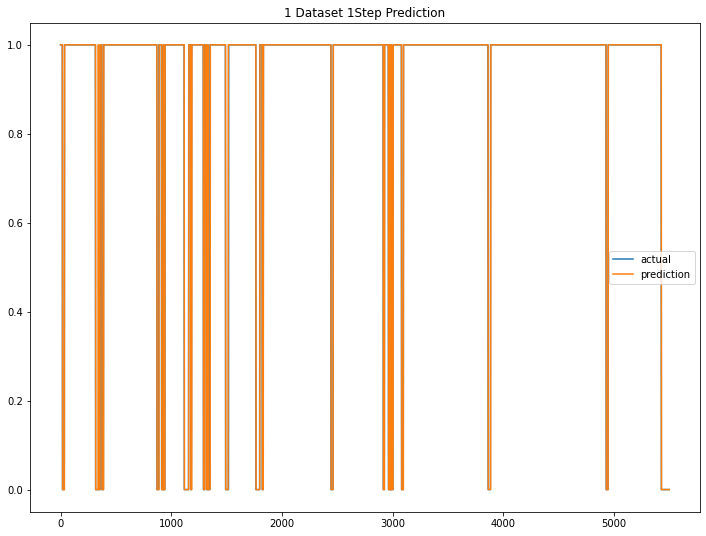

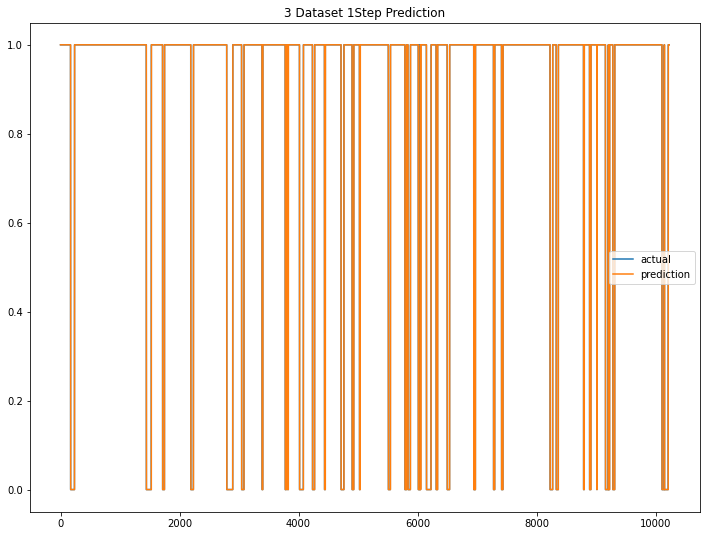

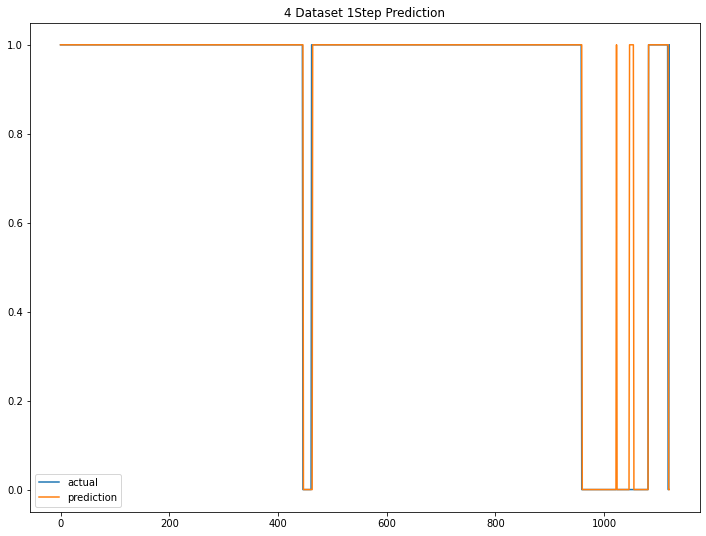

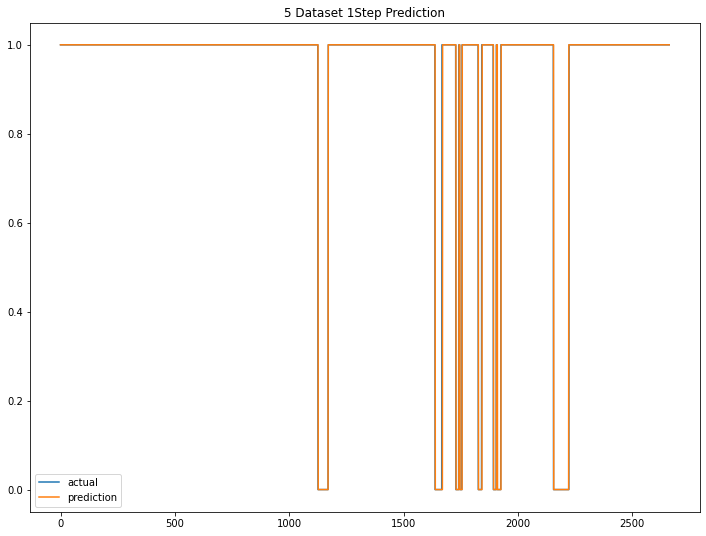

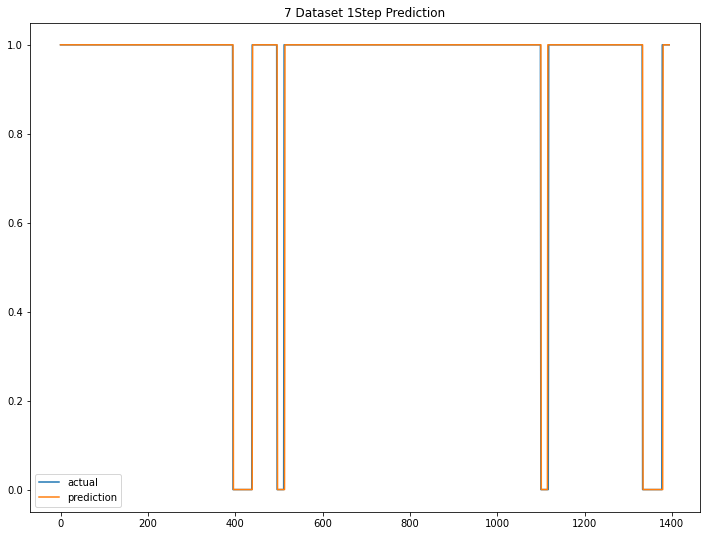

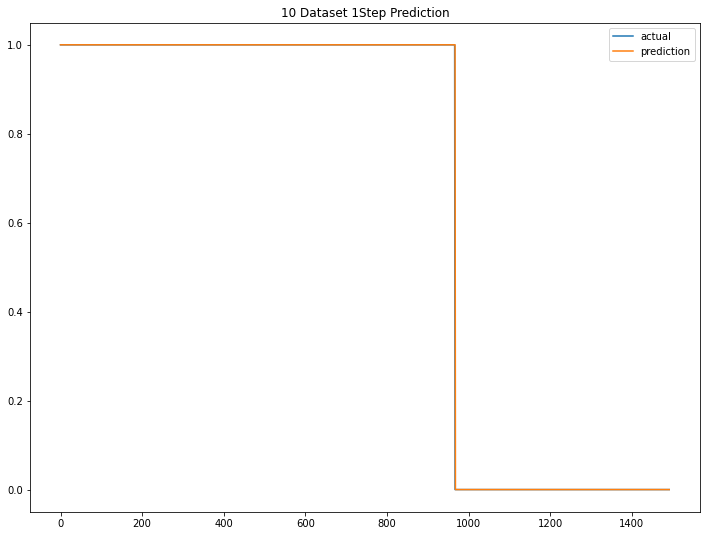

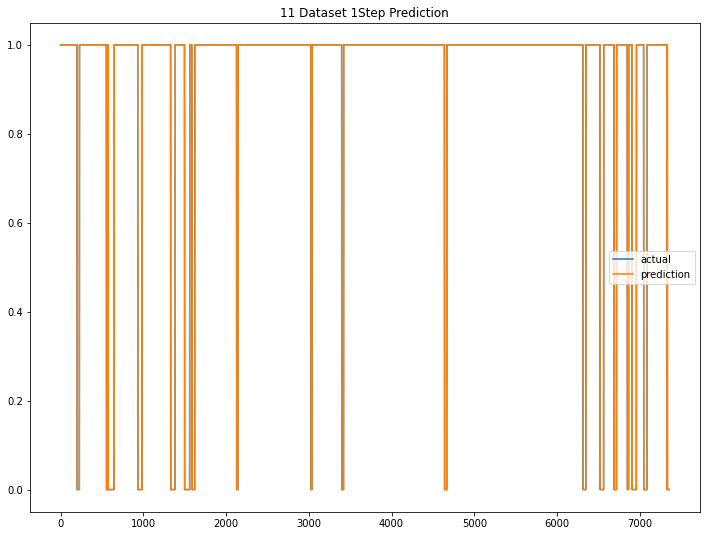

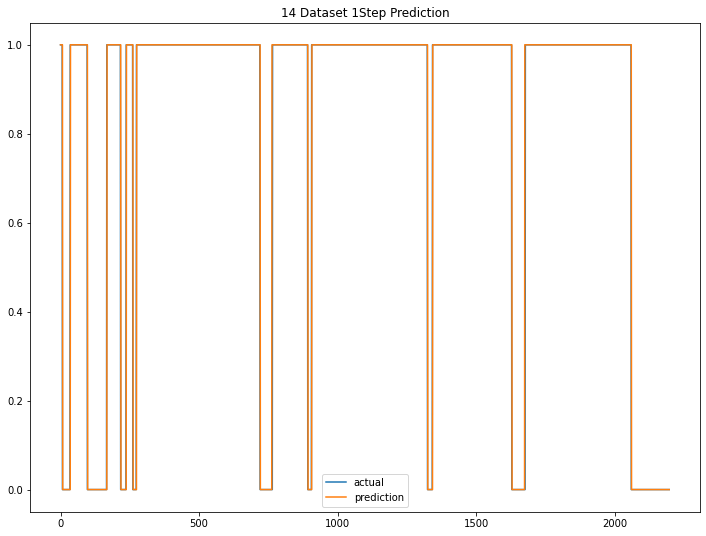

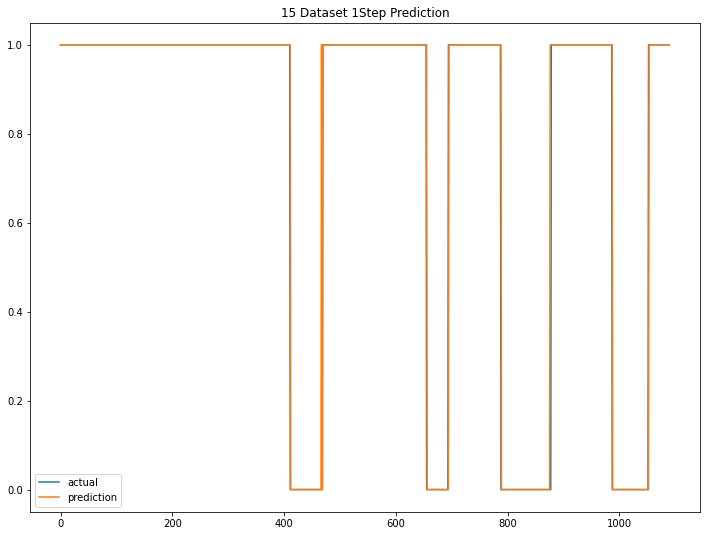

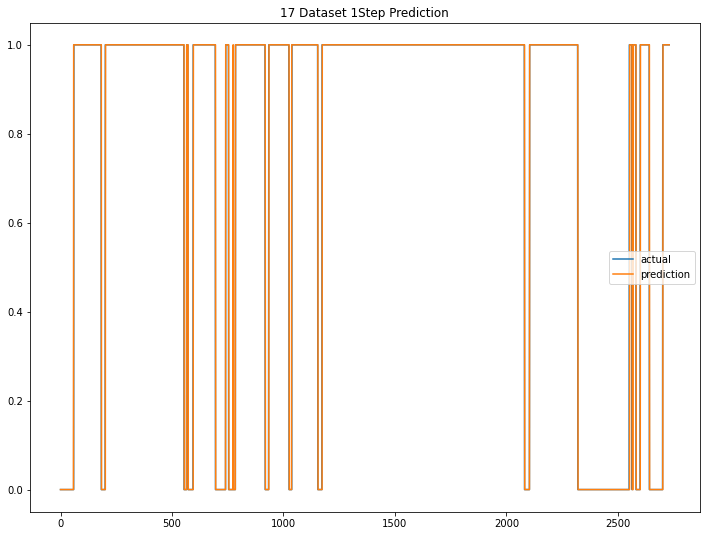

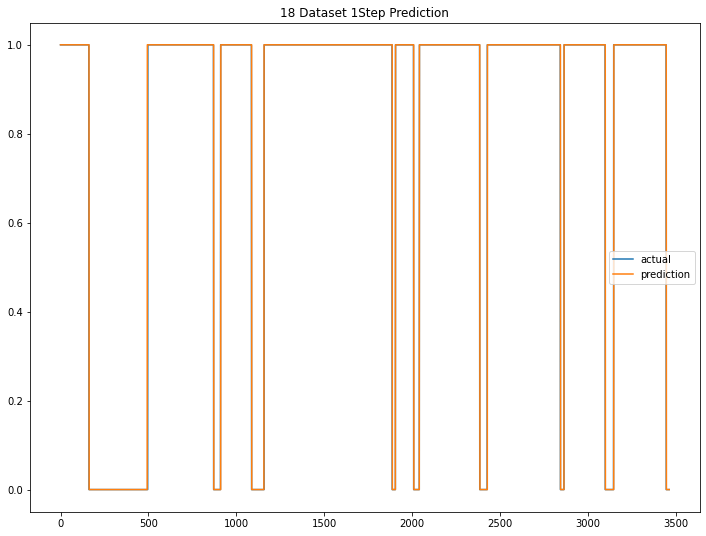

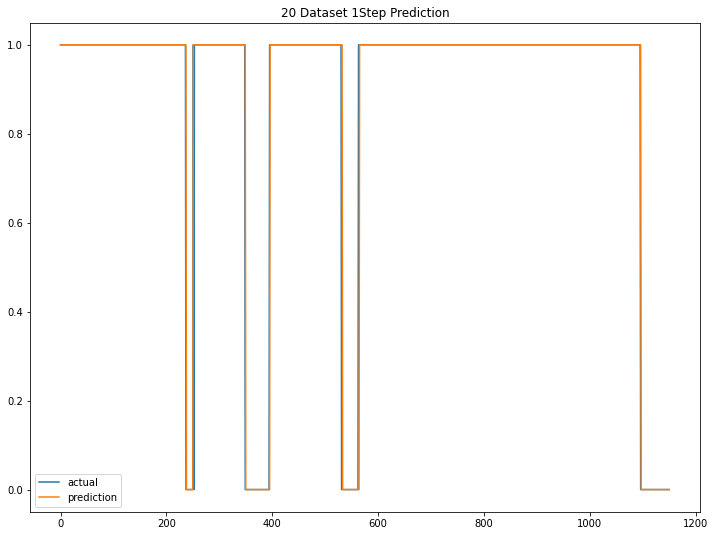

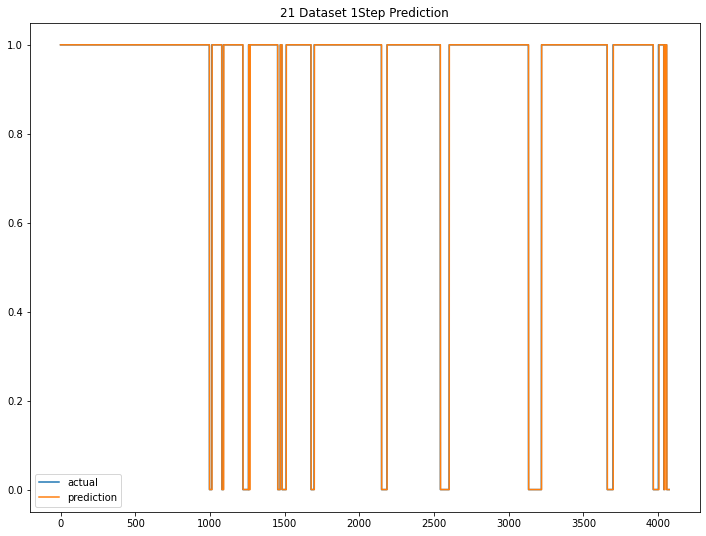

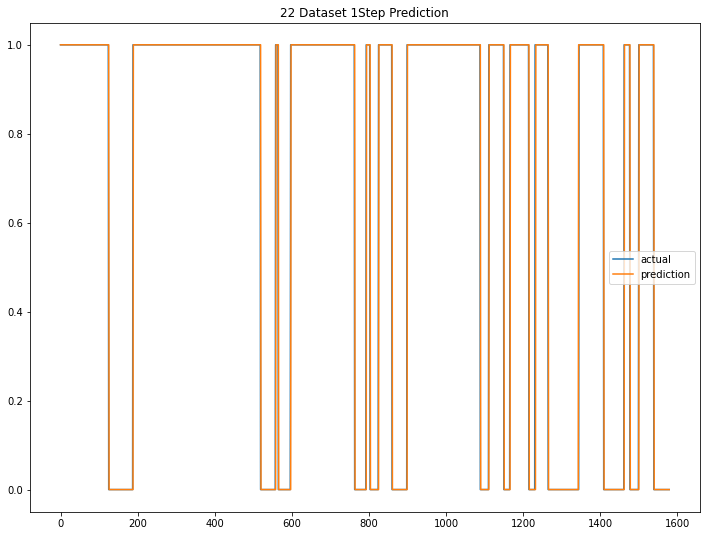

In [15]:
for i in idxs:
    plt.figure(figsize=(12, 9))
    plt.plot(locals()['testY{}'.format(i)][:,0], label='actual')
    plt.plot(locals()['pred{}'.format(i)][:,0], label='prediction')
    plt.legend()
    plt.title('{} Dataset 1Step Prediction'.format(i+1))
    # plt.xlim(0,2000)
    # plt.ylim(-0.1, 1.1)
    plt.show()

In [17]:
Accuracy = []
FalsePositiveRate = []
TruePositiveRate = []
Precision = []
Recall = []
for i in idxs:
    temp1 = []
    temp2 = []
    temp3 = []
    temp4 = []
    temp5 = []
    for k in range(predict_length):
        TP = 0
        TN = 0
        FP = 0
        FN = 0

        for j in range(len(locals()['pred{}'.format(i)])):

            if locals()['pred{}'.format(i)][j, k] == locals()['testY{}'.format(i)][j, k]:
                if locals()['pred{}'.format(i)][j, k] == 1:
                    TN += 1
                else:
                    TP += 1
            else:
                if locals()['pred{}'.format(i)][j, k] == 1:
                    FP += 1
                else:
                    FN += 1

        temp1.append((TP + TN)/(TP + TN + FP + FN)) # Accuracy
        temp2.append(FP/(FP + TN))                  # FalsePositiveRate
        temp3.append(TP/(TP + FP))                  # Precision
        temp4.append(TP/(TP + FN))                  # Recall
    #     print('{} dataset {} Step Prediction Accuracy: '.format(i+1,k+1), temp1[-1], '    False Positive Rate: ', temp2[-1], '    Precision: ', temp3[-1], '    Recall: ', temp4[-1])
    # print('='*150)

    if Accuracy == []:
        Accuracy = np.array(temp1).reshape(-1,1)
        FalsePositiveRate = np.array(temp2).reshape(-1,1)
        Precision = np.array(temp3).reshape(-1,1)
        Recall = np.array(temp4).reshape(-1,1)
    else:
        temp1 = np.array(temp1).reshape(-1,1)
        buf = np.hstack((Accuracy, temp1))
        Accuracy = buf
        temp2 = np.array(temp2).reshape(-1,1)
        buf = np.hstack((FalsePositiveRate, temp2))
        FalsePositiveRate = buf
        temp3 = np.array(temp3).reshape(-1,1)
        buf = np.hstack((Precision, temp3))
        Precision = buf
        temp4 = np.array(temp4).reshape(-1,1)
        buf = np.hstack((Recall, temp3))
        Recall = buf        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [18]:
AccuracyResult = np.mean(Accuracy, axis = 1)
FPRResult = np.mean(FalsePositiveRate, axis = 1)
PrecisionResult = np.mean(Precision, axis = 1)
RecallResult = np.mean(Recall, axis = 1)
for i in range(len(AccuracyResult)):
    print('{} Step Accuracy Result: '.format(i+1), round(AccuracyResult[i], 4), '    {} Step FalsePositiveRate Result: '.format(i+1), round(FPRResult[i], 4), '    {} Step Precision Result: '.format(i+1), round(PrecisionResult[i], 4), '    {} Step Recall Result: '.format(i+1), round(RecallResult[i], 4))

1 Step Accuracy Result:  0.9912     1 Step FalsePositiveRate Result:  0.0061     1 Step Precision Result:  0.9628     1 Step Recall Result:  0.9632
2 Step Accuracy Result:  0.9859     2 Step FalsePositiveRate Result:  0.0112     2 Step Precision Result:  0.9318     2 Step Recall Result:  0.9351
3 Step Accuracy Result:  0.9817     3 Step FalsePositiveRate Result:  0.0164     3 Step Precision Result:  0.8995     3 Step Recall Result:  0.9068
4 Step Accuracy Result:  0.9779     4 Step FalsePositiveRate Result:  0.0212     4 Step Precision Result:  0.8705     4 Step Recall Result:  0.881
5 Step Accuracy Result:  0.9739     5 Step FalsePositiveRate Result:  0.0259     5 Step Precision Result:  0.8418     5 Step Recall Result:  0.8559
6 Step Accuracy Result:  0.9701     6 Step FalsePositiveRate Result:  0.0306     6 Step Precision Result:  0.813     6 Step Recall Result:  0.8303
7 Step Accuracy Result:  0.9658     7 Step FalsePositiveRate Result:  0.035     7 Step Precision Result:  0.7845  